### Importando las librerias

In [63]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

### Importando los datasets

In [64]:
df_train_values = pd.read_csv('../datasets/train_values.csv')
df_train_labels = pd.read_csv('../datasets/train_labels.csv')

### Daño por diseño antisismico

Una hipótesis obvia, es que algunas construcciones antisismicas fueron mas efectivas que otras. Puede también influir otros factores como el año de construcción o la cantidad de pisos. Serán otros desarrollos.

#### Filtro los datos

In [66]:
df_plan_configuration_filtered = df_train_values.loc[:, ['building_id', 'plan_configuration']]

#### Calculo el total por configuración

In [71]:
total_buildings_by_plan_conf = df_plan_configuration_filtered.groupby('plan_configuration')\
    .count()\
    .reset_index()\
    .rename(columns = {'building_id': 'total_buildings_by_plan_configuration'})
total_buildings_by_plan_conf

,plan_configuration,total_buildings_by_plan_configuration
0,a,252
1,c,325
2,d,250072
3,f,22
4,m,46
5,n,38
6,o,159
7,q,5692
8,s,346
9,u,3649


#### Hago el merge de los datos

In [75]:
df_merged_with_plan_and_damage = df_train_labels\
    .merge(df_plan_configuration_filtered)\
    .merge(total_buildings_by_plan_conf)
df_merged_with_plan_and_damage

,building_id,damage_grade,plan_configuration,total_buildings_by_plan_configuration
0,802906,3,d,250072
1,28830,2,d,250072
2,94947,3,d,250072
3,590882,2,d,250072
4,201944,3,d,250072
...,...,...,...,...
260596,226273,1,o,159
260597,335301,2,o,159
260598,196656,2,o,159
260599,517707,2,o,159


In [84]:
df_merged_with_plan_and_damage\
    .groupby(['plan_configuration', 'damage_grade', 'total_buildings_by_plan_configuration'])\
    .count()

building_id
plan_configuration damage_grade total_buildings_by_plan_configuration             
a                  1            252                                             66
                   2            252                                            157
                   3            252                                             29
c                  1            325                                             86
                   2            325                                            206
                   3            325                                             33
d                  1            250072                                       23310
                   2            250072                                      142523
                   3            250072                                       84239
f                  2            22                                              16
                   3            22                                               6
m                  1            46                                               8
                   2            46                                              34
                   3            46                                               4
n                  1            38                                               6
                   2            38                                              20
                   3            38                                              12
o                  1            159                                             40
                   2            159                                             96
                   3            159                                             23
q                  1            5692                                           781
                   2            5692                                          2585
                   3            5692                                          2326
s                  1            346                                             53
                   2            346                                            223
                   3            346                                             70
u                  1            3649                                           774
                   2            3649                                          2399
                   3            3649                                           476

In [83]:
df_plan_and_damage_with_percentage = df_merged_with_plan_and_damage\
    .groupby(['plan_configuration', 'damage_grade', 'total_buildings_by_plan_configuration'])\
    .count()\
    .reset_index()\
    .rename(columns = { 'building_id': 'total_buildings_by_plan_and_damage' })

df_plan_and_damage_with_percentage['percentage'] = (df_plan_and_damage_with_percentage['total_buildings_by_plan_and_damage'] * 100) / df_plan_and_damage_with_percentage['total_buildings_by_plan_configuration']
df_plan_and_damage_with_percentage

,plan_configuration,damage_grade,total_buildings_by_plan_configuration,total_buildings_by_plan_and_damage,percentage
0,a,1,252,66,26.19
1,a,2,252,157,62.30
2,a,3,252,29,11.51
3,c,1,325,86,26.46
4,c,2,325,206,63.38
5,c,3,325,33,10.15
6,d,1,250072,23310,9.32
7,d,2,250072,142523,56.99
8,d,3,250072,84239,33.69
9,f,2,22,16,72.73


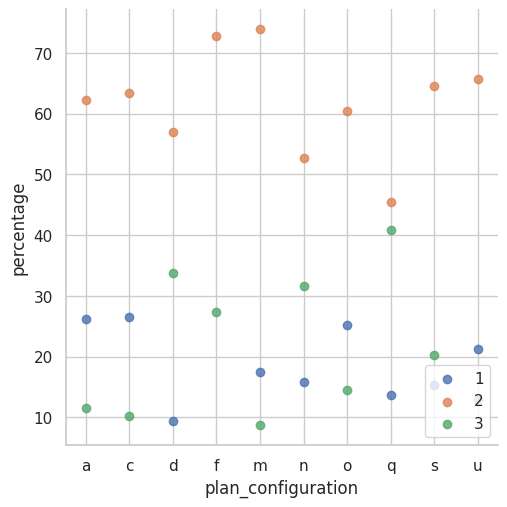

In [27]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="plan_configuration", y="percentage", data=df_plan_and_damage_with_percentage, fit_reg=False, hue='damage_grade', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

In [62]:
df_merged_with_plan_and_damage_2 = df_train_labels\
    .merge(df_train_values)

loc_filter = (df_merged_with_plan_and_damage['damage_grade'] == 3) & (df_merged_with_plan_and_damage['plan_configuration'] == 'a')
df_merged_with_plan_and_damage.loc[loc_filter, ['age']].head(5)

,age
2977,30
24078,0
33789,15
43722,0
54894,45


In [61]:
df_merged_with_plan_and_damage_3 = df_train_labels\
    .merge(df_train_values)

loc_filter = df_merged_with_plan_and_damage['plan_configuration'] == 'a'
df_merged_with_plan_and_damage.loc[loc_filter, :].head(5)

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
926,117310,2,25,50,1097,2,120,7,5,t,...,0,0,0,0,0,0,0,0,0,0
1762,708065,1,20,826,5879,1,10,2,4,o,...,0,0,0,0,0,0,0,0,0,0
2331,546507,1,1,567,11886,1,15,8,3,n,...,0,0,0,0,0,0,0,0,0,0
2977,871169,3,21,107,4069,3,30,11,6,t,...,0,0,0,0,0,0,0,0,0,0
3823,95095,1,8,463,8236,3,10,13,9,t,...,0,0,0,0,0,0,0,0,0,0
